In [ ]:
 from matplotlib import pyplot as plt
 import tensorflow as tf
 import numpy as np
 import pandas as pd
 from tensorflow import keras
 from tensorflow.keras import layers
 from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_ds = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/cw1_DL/seg_train',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
val_ds = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/cw1_DL/seg_test',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath='./',
                             monitor = 'val_accuracy',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')
early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-11-08 12:56:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  28.4MB/s    in 3.0s    

2022-11-08 12:56:42 (28.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None,
                                classifier_activation="softmax",)

# Load the pre-trained weights downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Choose `mixed_7` as the last layer of base model
last_layer = pre_trained_model.get_layer('mixed8')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1280)


In [ ]:
last_output = pre_trained_model.output

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(6, activation='softmax')(x)  
model = Model(pre_trained_model.input, x) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Train the model.
history = model.fit(
            train_ds,
            validation_data = val_ds,
            epochs = 15, callbacks=[reduce_lr])

Epoch 1/15
220/220 [==============================] - 207s 882ms/step - loss: 1.2321 - accuracy: 0.6869 - val_loss: 0.4179 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 2/15
220/220 [==============================] - 190s 865ms/step - loss: 0.6924 - accuracy: 0.7733 - val_loss: 0.3436 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 3/15
220/220 [==============================] - 190s 862ms/step - loss: 0.6145 - accuracy: 0.7934 - val_loss: 0.3012 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 4/15
220/220 [==============================] - 190s 864ms/step - loss: 0.5605 - accuracy: 0.8055 - val_loss: 0.3089 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 5/15
220/220 [==============================] - 190s 864ms/step - loss: 0.4940 - accuracy: 0.8276 - val_loss: 0.2801 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 6/15
220/220 [==============================] - 191s 867ms/step - loss: 0.4510 - accuracy: 0.8411 - val_loss: 0.2872 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 7/15
220/220 [==========================

In [ ]:
model.save('classification_model.h5')

In [ ]:
import cv2
img = cv2.imread('../input/sea-test/8f99428711bfe601833337b06fb3e390.jpg')
img = cv2.resize(img, (224,224))
img = np.expand_dims(img, 0)
img = img/255

model.predict(img)

In [ ]:
# ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


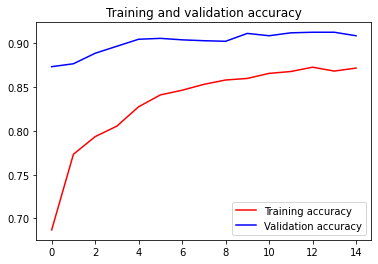

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title 
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

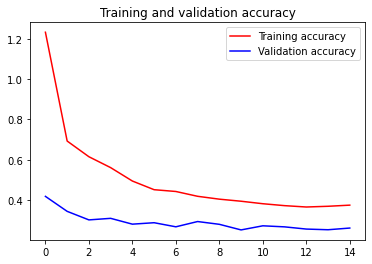

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title 
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model= tf.keras.models.load_model('model.h5')

In [ ]:
from sklearn.metrics import accuracy_score

predictions = model.predict(train_test)    
pred_labels = np.argmax(predictions, axis = 1)
#print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

In [ ]:
submission = pd.DataFrame({'Img':car.index,'Label':pred_labels}) 
submission.Img = submission.Id.apply(lambda x: x+1)
submission.head(10)